# **Exploratory Data Analysis**

## **This Notebook**
In this notebook we will perfom Exploratory Data Analysis to
- Handle missing values
- Clean the image dataset by removing non-poster images
- Cluster movie genres into five thematic macro-groups
- Download posters

### **1.1 Import necessary libaries**

In [3]:
import os
import pandas as pd
import numpy as np
import requests
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import MultiLabelBinarizer

### **1.2 Load the movie dataset**

In [5]:
df = pd.read_csv('movies_dataset_final.csv')

In [6]:
df.head()

,Unnamed: 0,tconst,title,year,genre,director,actors,plot,country,awards,poster,rating,votes,type
0,1,tt3608918,Azzurrina,2023,Horror,Giacomo Franciosa,"Tatiana Luter, Paolo Stella, Gianfranco Terrin",The tale of Guendalina was passed down verball...,Italy,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BOWQ5MG...,9.0,10,movie
1,2,tt15908496,Dear Jackie,2021,Documentary,Henri Pardo,"Ronald Jones, Ivan Livingstone, Majiza Philips",Dear Jackie paints a picture of the Black comm...,Canada,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BNDIwYz...,7.5,16,movie
2,3,tt28378602,Zena s gumenim rukavicama,2023,Drama,Mario Sulina,"Areta Curkovic, Sandra Loncaric, Miro Cabraja",The film was inspired by the great strike of e...,Croatia,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BODE4NG...,7.1,36,movie
3,4,tt27129223,Fast Shark II: Faster Shark,2023,"Comedy, Sci-Fi",Chloe Pelletier,"Grace Barrington, John Bradshaw, Josefa Calero",A fast shark that has grown even faster contin...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BYWY0NT...,7.7,79,movie
4,5,tt15173938,Shooting Guard,2022,Thriller,Luke Ostermiller,"Agapi Petra, Myles Juniel, Exzinia Scott",In an effort to save his mom from being evicte...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BN2FjZD...,8.2,7,movie


In [7]:
# Drop the "Unnamed: 0" column
df = df.drop("Unnamed: 0", axis=1)

### **2. Handling missing values**

In [9]:
df.isnull().sum()

tconst        0
title         1
year          0
genre         0
director    260
actors        0
plot        279
country       0
awards        0
poster      942
rating        0
votes         0
type          0
dtype: int64

The dataset contains **942 missing values** in the **“poster” feature**. This means that the image dataset does not include posters for these movies, as they were not downloaded during the data collection phase. Therefore, these rows will be deleted.

In [11]:
df = df.dropna(subset=['poster'])

In [12]:
df.isnull().sum()

tconst        0
title         1
year          0
genre         0
director    235
actors        0
plot        252
country       0
awards        0
poster        0
rating        0
votes         0
type          0
dtype: int64

For now, we won't handle the missing values in the other features.

### **3. Removing non-poster images**

We observe that **real movie posters** typically have a **height-to-width (h/w) ratio of around 1.5.** As a first step, we create a histogram of poster shape ratios to understand their distribution.

In [16]:
# Empty list for storing poster shape ratios
ratios = []

# Iterate over each movie ID in the 'tconst' column of the DataFrame
for id in df['tconst']:
    try: 
        # Construct the image file path based on the movie ID
        image_path = 'Data/' + id + '.jpg'

        # Open the image file
        image = Image.open(image_path)

        # Convert the image into a NumPy array
        image_array = np.array(image)

        # Compute the shape ratio (height/width) of the image
        shape_ratio = image_array.shape[0] / image_array.shape[1]

        # Append the computed ratio to the list
        ratios.append(shape_ratio)

        # Add a "shape" column to the DataFrame
        df.loc[df["tconst"] == id, "shape"] = shape_ratio

    # Handle the case where the image file is missing
    except FileNotFoundError:
        # Remove the row corresponding to the missing poster from the DataFrame
        df = df[df["tconst"] != id]

    # Handle cases where the image file is corrupted or not a valid image
    except UnidentifiedImageError:
        # Remove the row corresponding to the invalid poster from the DataFrame
        df = df[df["tconst"] != id]

        # Delete the corrupted or unrecognized image file from the directory
        os.remove(image_path)

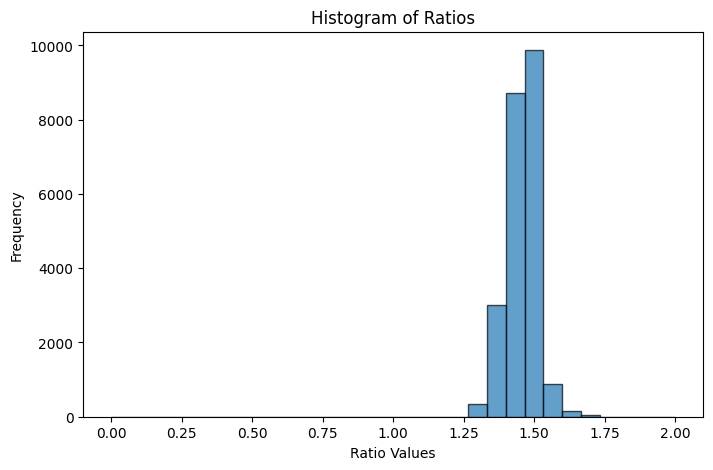

In [17]:
# Create a new figure with a specified size (width=8 inches, height=5 inches)
plt.figure(figsize=(8, 5))

# Plot a histogram of the 'ratios' list
# - bins=20: Divides the range into 20 bins for better granularity
# - range=(0, 2): Limits the x-axis values from 0 to 2
# - edgecolor='black': Adds black borders to bars for better visibility
# - alpha=0.7: Sets transparency level to make bars slightly see-through
plt.hist(ratios, bins=30, range=(0, 2), edgecolor='black', alpha=0.7)

# Add labels and title to the histogram
plt.xlabel("Ratio Values")  # Label for the x-axis
plt.ylabel("Frequency")      # Label for the y-axis
plt.title("Histogram of Ratios")  # Title of the plot

# Display the histogram
plt.show()

We delete all movies with a poster shape ratio **greater than 1.7** or **less than 1.3.**

In [19]:
# Filter rows where shape is within the range (1.3, 1.7)
movies_to_delete = df[(df["shape"] > 1.7) | (df["shape"] < 1.3)]

# Iterate over movies to delete
for movie_id in movies_to_delete["tconst"]:
    image_path = f'Data/{movie_id}.jpg'  # Construct file path
    
    # Check if the file exists before attempting to delete
    if os.path.exists(image_path):
        os.remove(image_path)  # Delete the file
    
# Remove the filtered rows from the DataFrame
df = df[(df["shape"] <= 1.7) & (df["shape"] >= 1.3)]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23005 entries, 0 to 28878
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tconst    23005 non-null  object 
 1   title     23005 non-null  object 
 2   year      23005 non-null  object 
 3   genre     23005 non-null  object 
 4   director  23005 non-null  object 
 5   actors    23005 non-null  object 
 6   plot      23005 non-null  object 
 7   country   23005 non-null  object 
 8   awards    23005 non-null  object 
 9   poster    23005 non-null  object 
 10  rating    23005 non-null  float64
 11  votes     23005 non-null  int64  
 12  type      23005 non-null  object 
 13  shape     23005 non-null  float64
dtypes: float64(2), int64(1), object(11)
memory usage: 2.6+ MB


### **4. Additional cleaning**

In [22]:
df.columns

Index(['tconst', 'title', 'year', 'genre', 'director', 'actors', 'plot',
       'country', 'awards', 'poster', 'rating', 'votes', 'type', 'shape'],
      dtype='object')

In [23]:
# Checking the content type
df.type.value_counts()

type
movie    23005
Name: count, dtype: int64

In [24]:
# Because we only have 4 series types, these will be delated

# Identify rows where "type" is "series"
content_to_delete = df[df["type"] == "series"]

# Iterate over each "series" entry and delete the corresponding image file
for movie_id in content_to_delete["tconst"]:
    image_path = f'Data/{movie_id}.jpg'  # Construct the file path
    
    # Check if the file exists before attempting to delete
    if os.path.exists(image_path):
        os.remove(image_path)  # Delete the file
    
# Remove the "series" rows from the DataFrame
df = df[df["type"] != "series"]

# Display updated type counts to verify deletion
print(df["type"].value_counts())

type
movie    23005
Name: count, dtype: int64


### **5. Movie genre analysis**

In [62]:
# Checking the movie genres in the dataset
multigenre = df.genre.value_counts()

with open("multigenre.txt", "w") as file:
    file.write(multigenre.to_string())

In [41]:
# Split the 'genre' column into list of genres
df['genre_list'] = df['genre'].str.split(',\s*')

# One-Hot Encoding the “genre” Feature
mlb = MultiLabelBinarizer()
one_hot_genres = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_)
df = df.join(one_hot_genres)

df.head()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dk/nwt6ddv12cd3hjtm1brdfz2m0000gn/T/ipykernel_29903/3331658413.py:2: SyntaxWarning: invalid escape sequence '\s'
  df['genre_list'] = df['genre'].str.split(',\s*')


,tconst,title,year,genre,director,actors,plot,country,awards,poster,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,tt3608918,Azzurrina,2023,Horror,Giacomo Franciosa,"Tatiana Luter, Paolo Stella, Gianfranco Terrin",The tale of Guendalina was passed down verball...,Italy,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BOWQ5MG...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt15908496,Dear Jackie,2021,Documentary,Henri Pardo,"Ronald Jones, Ivan Livingstone, Majiza Philips",Dear Jackie paints a picture of the Black comm...,Canada,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BNDIwYz...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt28378602,Zena s gumenim rukavicama,2023,Drama,Mario Sulina,"Areta Curkovic, Sandra Loncaric, Miro Cabraja",The film was inspired by the great strike of e...,Croatia,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BODE4NG...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt27129223,Fast Shark II: Faster Shark,2023,"Comedy, Sci-Fi",Chloe Pelletier,"Grace Barrington, John Bradshaw, Josefa Calero",A fast shark that has grown even faster contin...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BYWY0NT...,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt15173938,Shooting Guard,2022,Thriller,Luke Ostermiller,"Agapi Petra, Myles Juniel, Exzinia Scott",In an effort to save his mom from being evicte...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BN2FjZD...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [43]:
one_hot_genres

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23000,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23001,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23002,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23003,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/var/folders/dk/nwt6ddv12cd3hjtm1brdfz2m0000gn/T/ipykernel_29903/360731704.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(genre_count.index, rotation=90);


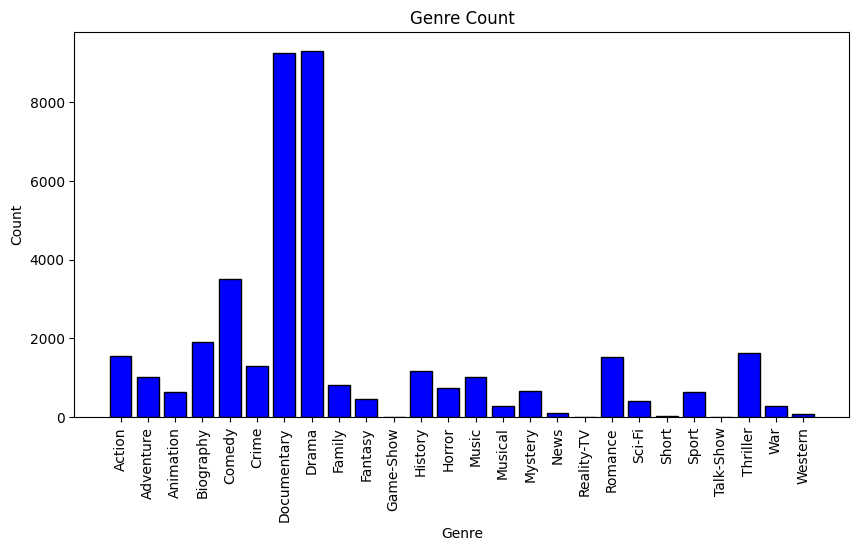

In [45]:
# genre distribution

genre_count = one_hot_genres.sum()

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(genre_count.index, genre_count.values, color='blue', edgecolor='black')
ax.set_xlabel("Genre")
ax.set_ylabel("Count")
ax.set_title("Genre Count")
ax.set_xticklabels(genre_count.index, rotation=90);

In [47]:
# count rows with more than one genre
multi_genre_images = (one_hot_genres.sum(axis=1) > 1).sum()

print(f"Number of images with more than one genre: {multi_genre_images}")

Number of images with more than one genre: 10318


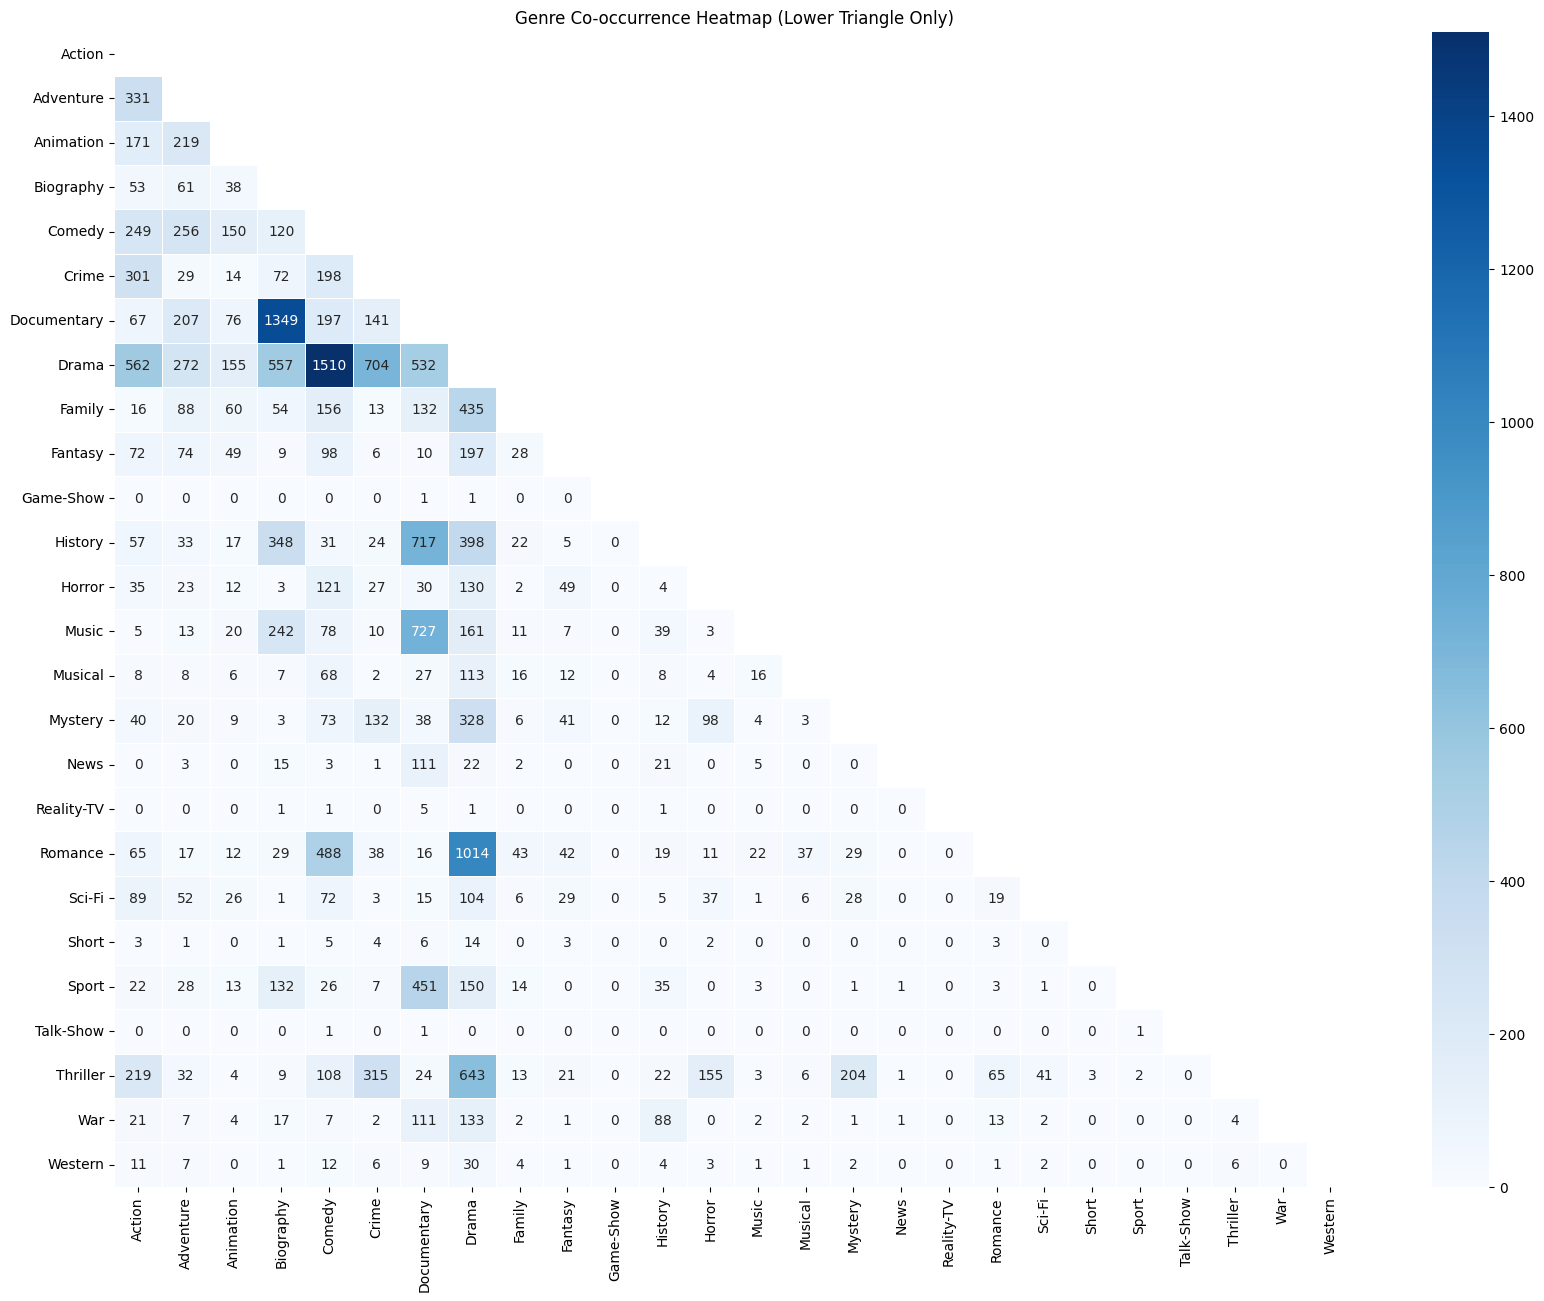

In [51]:
# Create co-occurrence matrix
# The diagonal values show how often a category appears individually
# The off-diagonal values show how often two categories appear together
co_occurrence = one_hot_genres.T.dot(one_hot_genres)

# Create a mask for the upper triangle (excluding the diagonal)
mask = np.triu(np.ones_like(co_occurrence, dtype=bool))

# Create a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(co_occurrence, annot=True, cmap="Blues", fmt=".0f", linewidths=0.5, mask=mask)

plt.title("Genre Co-occurrence Heatmap (Lower Triangle Only)")
plt.show()

Remove genres with few occurrences: "Game-Show", "Reality-TV", "Short", "Talk-Show"

In [54]:
# List of genres to eliminate
genres_to_remove = ["Game-Show", "Reality-TV", "Short", "Talk-Show"]

# Keep only rows where "genre" does not contain any of the unwanted genres
df = df[~df["genre"].str.contains("|".join(genres_to_remove), na=False)]

# Drop these genres from the one-hot encoded DataFrame (if already encoded)
one_hot_genres = one_hot_genres.drop(columns=genres_to_remove, errors="ignore")

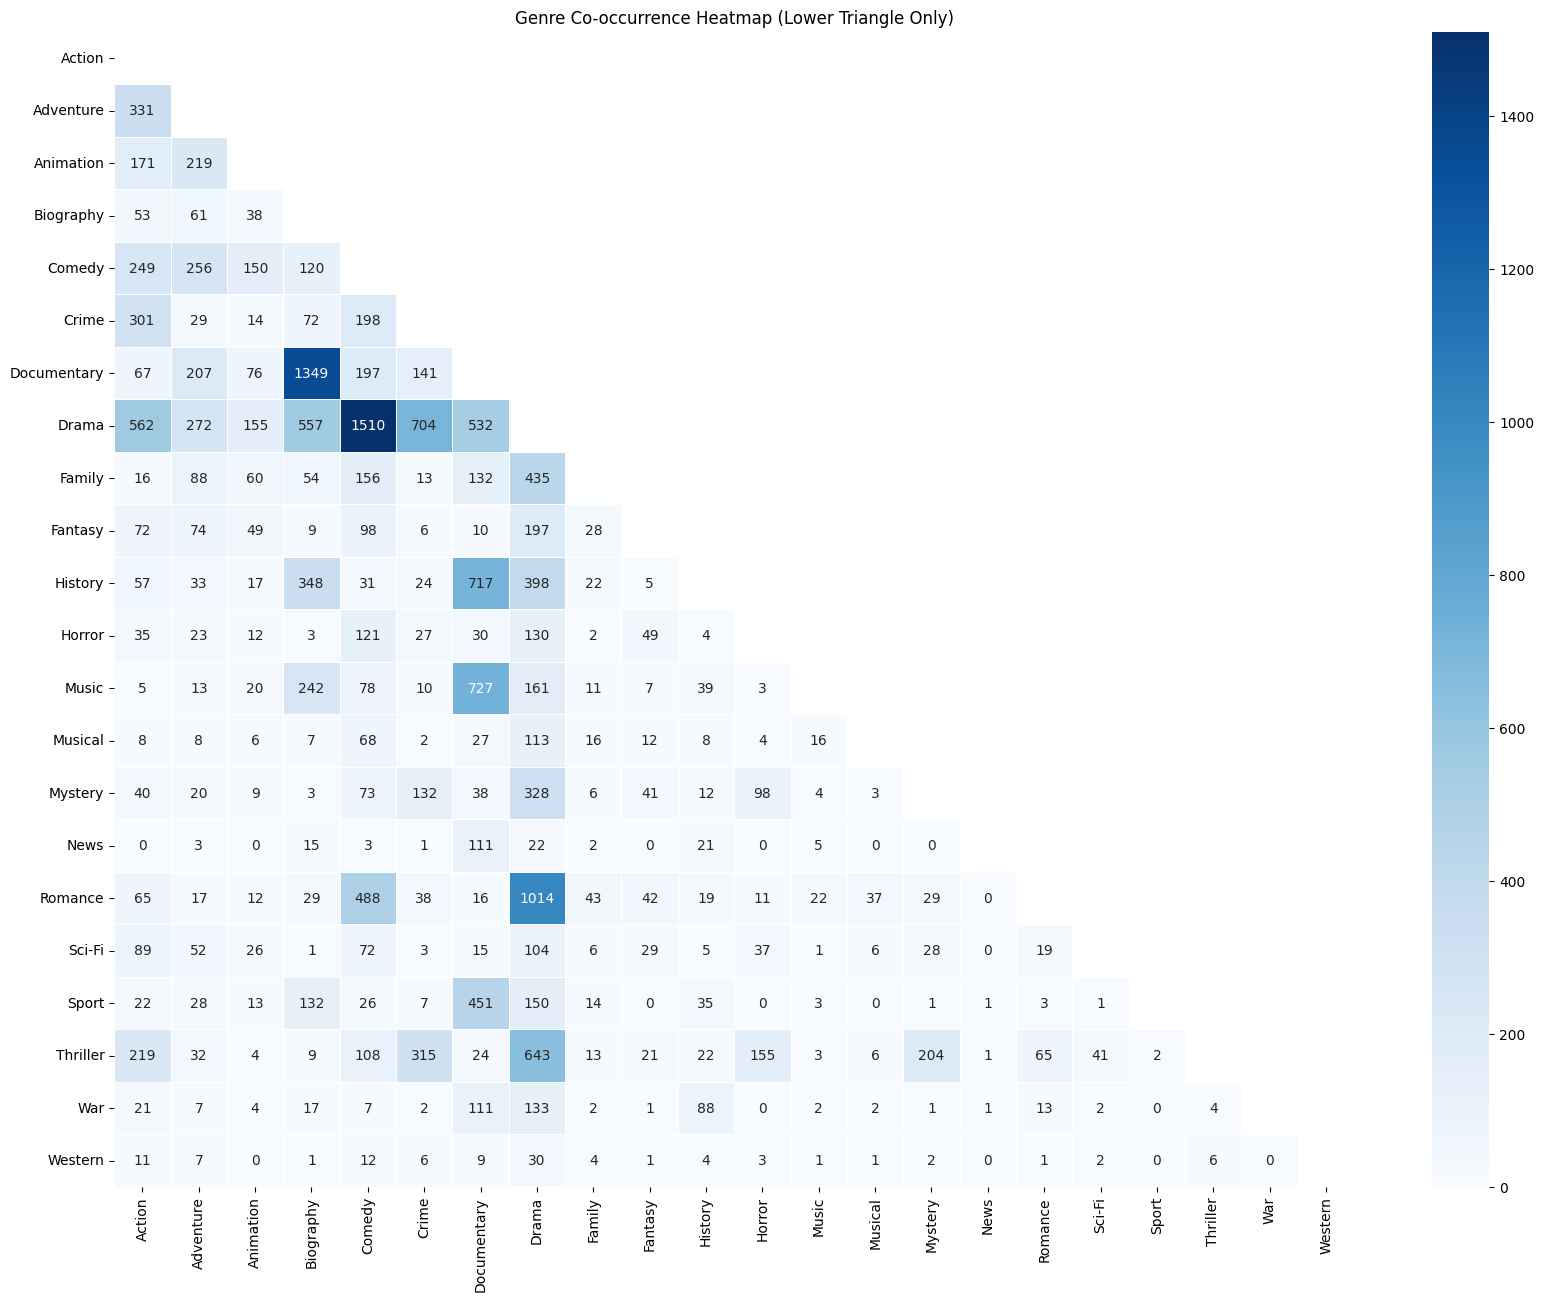

In [56]:
# Check co-occurences again
co_occurrence = one_hot_genres.T.dot(one_hot_genres)
mask = np.triu(np.ones_like(co_occurrence, dtype=bool))

# Create a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(co_occurrence, annot=True, cmap="Blues", fmt=".0f", linewidths=0.5, mask=mask)

plt.title("Genre Co-occurrence Heatmap (Lower Triangle Only)")
plt.show()

In [58]:
df.to_csv("movie_df_clean.csv")